### 1. BNN for binary classification (Iris dataset)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

iris = load_iris()
X = iris.data[:, :2]
y = (iris.target != 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

#### (1)&(2) Define Bayesian Neural Network and Variational Inference Loss
1. In the BNN class, we use learnable parameters $\theta$ to sample uncertain weights from normal distribution, i.e. to sample the weight $w$ from $\mathcal{N}(\mu,\sigma)$, we use
   $$w = \mu + \sigma\varepsilon,$$
   where $\varepsilon\sim\mathcal{N}(0,1)$. This is how variational inference works.
3. Following BNN, the loss is $$\text{Loss} = \log p(\mathcal{D}|w)+\log p_{\text{posterior}}(w|\theta) - \log p_{\text{prior}}(w)  $$

In [32]:
class BNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BNN, self).__init__()
        # Variational parameters for the weights and biases
        self.fc1_weight_mu = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.fc1_weight_std = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.fc1_bias_mu = nn.Parameter(torch.randn(hidden_dim))
        self.fc1_bias_std = nn.Parameter(torch.randn(hidden_dim))

        self.fc2_weight_mu = nn.Parameter(torch.randn(output_dim, hidden_dim))
        self.fc2_weight_std = nn.Parameter(torch.randn(output_dim, hidden_dim))
        self.fc2_bias_mu = nn.Parameter(torch.randn(output_dim))
        self.fc2_bias_std = nn.Parameter(torch.randn(output_dim))

        self.epsilon_fc1_weight = torch.randn_like(self.fc1_weight_std)
        self.epsilon_fc1_bias = torch.randn_like(self.fc1_bias_std)
        self.epsilon_fc2_weight = torch.randn_like(self.fc2_weight_std)
        self.epsilon_fc2_bias = torch.randn_like(self.fc2_bias_std)

    def forward(self, x):

        self.epsilon_fc1_weight = torch.randn_like(self.fc1_weight_std)
        self.epsilon_fc1_bias = torch.randn_like(self.fc1_bias_std)
        self.epsilon_fc2_weight = torch.randn_like(self.fc2_weight_std)
        self.epsilon_fc2_bias = torch.randn_like(self.fc2_bias_std)
        
        fc1_weight = self.fc1_weight_mu + torch.exp(self.fc1_weight_std) * self.epsilon_fc1_weight
        fc1_bias = self.fc1_bias_mu + torch.exp(self.fc1_bias_std) * self.epsilon_fc1_bias
        fc2_weight = self.fc2_weight_mu + torch.exp(self.fc2_weight_std) * self.epsilon_fc2_weight
        fc2_bias = self.fc2_bias_mu + torch.exp(self.fc2_bias_std) * self.epsilon_fc2_bias

        x = torch.relu(torch.matmul(x, fc1_weight.t()) + fc1_bias)  # Hidden layer
        x = torch.sigmoid(torch.matmul(x, fc2_weight.t()) + fc2_bias)  # Output layer

        return x
    def elbo_loss(self,x,y,prior_std=1.):
        
        y_pred = self.forward(x)
        
        fc1_weight = self.fc1_weight_mu + torch.exp(self.fc1_weight_std) * self.epsilon_fc1_weight
        fc1_bias = self.fc1_bias_mu + torch.exp(self.fc1_bias_std) * self.epsilon_fc1_bias
        fc2_weight = self.fc2_weight_mu + torch.exp(self.fc2_weight_std) * self.epsilon_fc2_weight
        fc2_bias = self.fc2_bias_mu + torch.exp(self.fc2_bias_std) * self.epsilon_fc2_bias          
        
        log_likelihood = -nn.functional.binary_cross_entropy(y_pred, y, reduction='sum')

        # Compute log prior (regularization term)
        prior = dist.Normal(0, prior_std)
        log_prior = prior.log_prob(fc1_weight).sum() + prior.log_prob(fc1_bias).sum() + \
                    prior.log_prob(fc2_weight).sum() + prior.log_prob(fc2_bias).sum()

        # Compute log variational posterior
        posterior_fc1_weight = dist.Normal(self.fc1_weight_mu, torch.exp(self.fc1_weight_std))
        posterior_fc1_bias = dist.Normal(self.fc1_bias_mu, torch.exp(self.fc1_bias_std))
        posterior_fc2_weight = dist.Normal(self.fc2_weight_mu, torch.exp(self.fc2_weight_std))
        posterior_fc2_bias = dist.Normal(self.fc2_bias_mu, torch.exp(self.fc2_bias_std))

        log_posterior = posterior_fc1_weight.log_prob(fc1_weight).sum() + \
                        posterior_fc1_bias.log_prob(fc1_bias).sum() + \
                        posterior_fc2_weight.log_prob(fc2_weight).sum() + \
                        posterior_fc2_bias.log_prob(fc2_bias).sum()

        elbo = log_likelihood + log_prior - log_posterior
        return -elbo  # Minimize negative ELBO

input_dim = X_train.shape[1]
hidden_dim = 10
output_dim = 1
bnn = BNN(input_dim, hidden_dim, output_dim)

# Define the optimizer
optimizer = optim.Adam(bnn.parameters(), lr=1e-2)

# Training loop
n_epochs = 1000
for epoch in range(n_epochs):
    optimizer.zero_grad()
    y_pred = bnn.forward(X_train)
    loss = bnn.elbo_loss(X_train,y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, prediction_accuracy: {np.round(((y_pred>0.5)==y_train).numpy().mean(),3)}")

# Evaluate the model
with torch.no_grad():
    y_pred = bnn(X_test)
    y_pred = y_pred>0.5
    accuracy = (y_pred == y_test).float().mean()
    print(f"Test Accuracy: {accuracy.item():.4f}")

Epoch [100/1000], Loss: 442.6090, prediction_accuracy: 0.6
Epoch [200/1000], Loss: 33.0230, prediction_accuracy: 0.867
Epoch [300/1000], Loss: 14.2515, prediction_accuracy: 0.967
Epoch [400/1000], Loss: 41.3057, prediction_accuracy: 0.967
Epoch [500/1000], Loss: 26.6564, prediction_accuracy: 0.9
Epoch [600/1000], Loss: 19.4106, prediction_accuracy: 0.7
Epoch [700/1000], Loss: 23.3733, prediction_accuracy: 0.833
Epoch [800/1000], Loss: 31.0897, prediction_accuracy: 0.9
Epoch [900/1000], Loss: 19.7636, prediction_accuracy: 0.967
Epoch [1000/1000], Loss: 21.8875, prediction_accuracy: 0.867
Test Accuracy: 0.9083


#### (3) Decision Boundary with uncertainty
1. After sampling the prediction for n_samples=100 times, we use the mean of output to set the decision boundary, and use the standard deviation of output as an indicator of uncertainty.
2. In the plot of uncertainty, we use size to represent the uncertainty, we can see that the larger the distance is away from the decision boundary and the larger density near the point, the uncertainty is smaller.

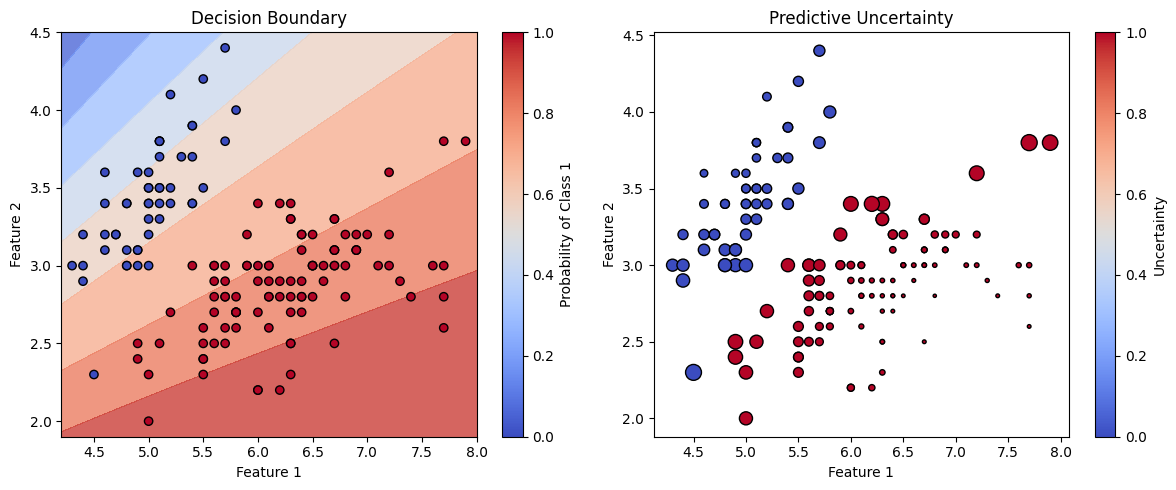

In [82]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, 
                        message="__array__ implementation doesn't accept a copy keyword.*")
n_samples = 1000
def predict_with_uncertainty(model, x, n_samples=n_samples):
    predictions = []
    for _ in range(n_samples):
        with torch.no_grad():
            y_pred = model(x)
            predictions.append(y_pred.numpy())
    predictions = np.array(predictions)
    mean_prediction = predictions.mean(axis=0)
    uncertainty = (predictions).std(axis=0)**2
    return mean_prediction, uncertainty

x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

mean_pred,_ = predict_with_uncertainty(bnn, grid_tensor)
_,uncertainty = predict_with_uncertainty(bnn,torch.tensor(scaler.transform(X),dtype=torch.float32))

mean_pred = mean_pred.reshape(xx.shape)

plt.figure(figsize=(12, 5))

# Decision boundary
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, mean_pred, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
plt.title("Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Probability of Class 1")

# Uncertainty
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1],c=y, s=n_samples*uncertainty.reshape(-1), edgecolors='k', marker='o', cmap = plt.cm.coolwarm)
plt.title("Predictive Uncertainty")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Uncertainty")

plt.tight_layout()
plt.show()

#### (4) Advantages of Bayesian Neural Networks:
1. Probabilistic Estimation: BNNs provide predictive uncertainty, which is useful for risk-sensitive applications.
2. Regularization and Robustness: The prior acts as a regularizer, this will reduce overfitting, and this also makes the model more robust

### 2. Bayesian Estimation of Gaussian Parameters

#### (1) Posterior Distribution for $\mu$ and $\sigma$
1. $$p(\mu|\sigma^{2},x_{i})\propto \exp{[-\dfrac{1}{2\sigma^{2}\tau^{2}}(\sigma^{2}(\mu-\mu_{0})^{2}+\tau^{2}\sum_{i=1}^{n}(x_{i}-\mu)^{2})]},$$
   thus, the posterior distribution of $\mu$ is
   $$\mu|\sigma^{2},x_{i}\sim \mathcal{N}(\dfrac{n\tau\overline{x}+\sigma^{2}\mu_{0}}{\sigma^{2}+n\tau^{2}},\dfrac{\sigma^{2}\tau^{2}}{\sigma^{2}+n\tau^{2}}).$$

   As for the $\sigma^{2}$, we have $$p(\sigma^{2}|\mu,x_{i})\propto \sigma^{-n}\exp{[-\dfrac{1}{2\sigma^{2}}(\sum_{i=1}^{n}(x_{i}-\mu)^{2})-\beta/\sigma^{2}-(\alpha+1)\log{\sigma^{2}}}], $$
   thus, the posterior distribution of $\sigma^{2}$ is
    $$\sigma^{2}|\mu,x_{i} \sim \text{Inverse Gamma}(\alpha+\frac{n}{2},\beta+\dfrac{\sum_{i=1}^{n}(x_{i}-\mu)^{2}}{2})$$

#### (2) Sampling 
1. We use Gibbs sampling: in each step, we update $(\mu_{0,n},\tau^{2}_{n})$ and $(\alpha_{n}, \beta_{n})$, then sample $\mu_{n},\sigma_{n}^{2}$ from the posterior distribution.

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, invgamma

np.random.seed(42)
mu_true = 5.0
sigma2_true = 2.0
n = 100
x = np.random.normal(mu_true, np.sqrt(sigma2_true), n)

mu_0 = 0.0
tau2 = 1.0  
alpha = 2.0
beta = 2.0

T = 10000  
burn_in = 1000  
mu_samples = np.zeros(T)
sigma2_samples = np.zeros(T)

mu_samples[0] = np.mean(x)
sigma2_samples[0] = np.var(x)

for t in range(1, T):

    f"""update posterior distribution of mu"""
    mu_n = (tau2 * n * np.mean(x)+sigma2_samples[t-1]*mu_0)/(sigma2_samples[t-1] + n*tau2)
    tau2_n = sigma2_samples[t-1]*tau2/(sigma2_samples[t-1]+n*tau2)
    mu_samples[t] = np.random.normal(mu_n, np.sqrt(tau2_n))

    f"""update posterior distribution of sigma"""
    alpha_n = alpha + n / 2
    beta_n = beta + 0.5 * np.sum((x - mu_samples[t])**2)
    sigma2_samples[t] = invgamma.rvs(a=alpha_n, scale=beta_n)

mu_samples = mu_samples[burn_in:]
sigma2_samples = sigma2_samples[burn_in:]

mu_bayes = np.mean(mu_samples)
sigma2_bayes = np.mean(sigma2_samples)
print(f"Bayesian Estimate: mu = {mu_bayes:.4f}, sigma^2 = {sigma2_bayes:.4f}")

Bayesian Estimate: mu = 4.7756, sigma^2 = 1.6606


#### (3) Visualization of MLE and Bayesian Approaches

MLE: mu = 4.8531, sigma^2 = 1.6330


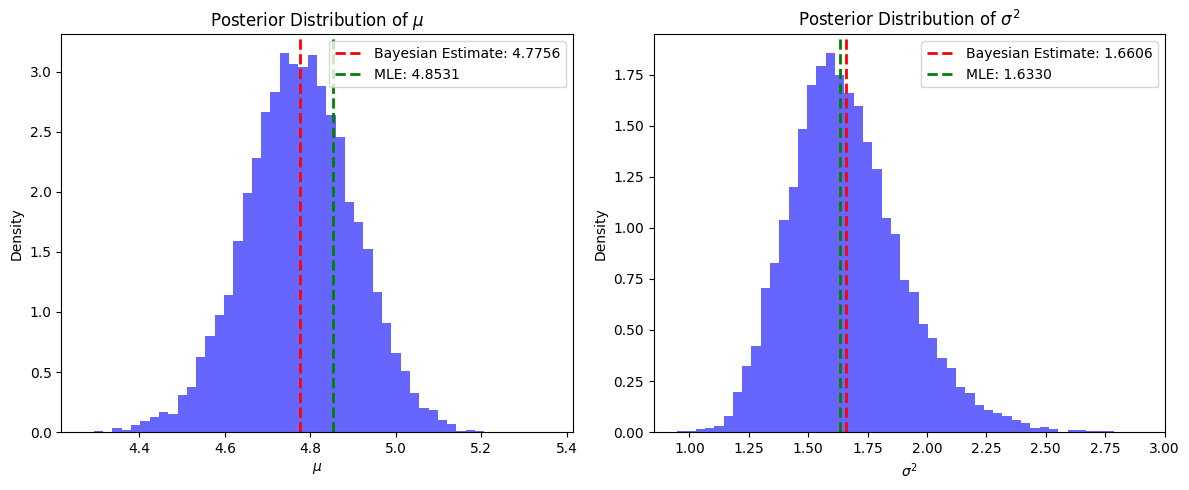

In [95]:
mu_mle = np.mean(x)
sigma2_mle = np.var(x, ddof=0)


print(f"MLE: mu = {mu_mle:.4f}, sigma^2 = {sigma2_mle:.4f}")

# Plot posterior distributions
plt.figure(figsize=(12, 5))

# Posterior for mu
plt.subplot(1, 2, 1)
plt.hist(mu_samples, bins=50, density=True, alpha=0.6, color='blue')
plt.axvline(mu_bayes, color='red', linestyle='dashed', linewidth=2, label=f"Bayesian Estimate: {mu_bayes:.4f}")
plt.axvline(mu_mle, color='green', linestyle='dashed', linewidth=2, label=f"MLE: {mu_mle:.4f}")
plt.title("Posterior Distribution of $\mu$")
plt.xlabel("$\mu$")
plt.ylabel("Density")
plt.legend()

# Posterior for sigma^2
plt.subplot(1, 2, 2)
plt.hist(sigma2_samples, bins=50, density=True, alpha=0.6, color='blue')
plt.axvline(sigma2_bayes, color='red', linestyle='dashed', linewidth=2, label=f"Bayesian Estimate: {sigma2_bayes:.4f}")
plt.axvline(sigma2_mle, color='green', linestyle='dashed', linewidth=2, label=f"MLE: {sigma2_mle:.4f}")
plt.title("Posterior Distribution of $\sigma^2$")
plt.xlabel("$\sigma^2$")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

### 3.Gibbs Sampler for One Sample Source Separation

#### (1) Experiment 1
Since we used a value close to the true posterior mean, we take burn-in step to be 1000 while the total iteration step is 10000.

Convergence within 5% for s1: 0 iterations
Convergence within 5% for s2: 1 iterations


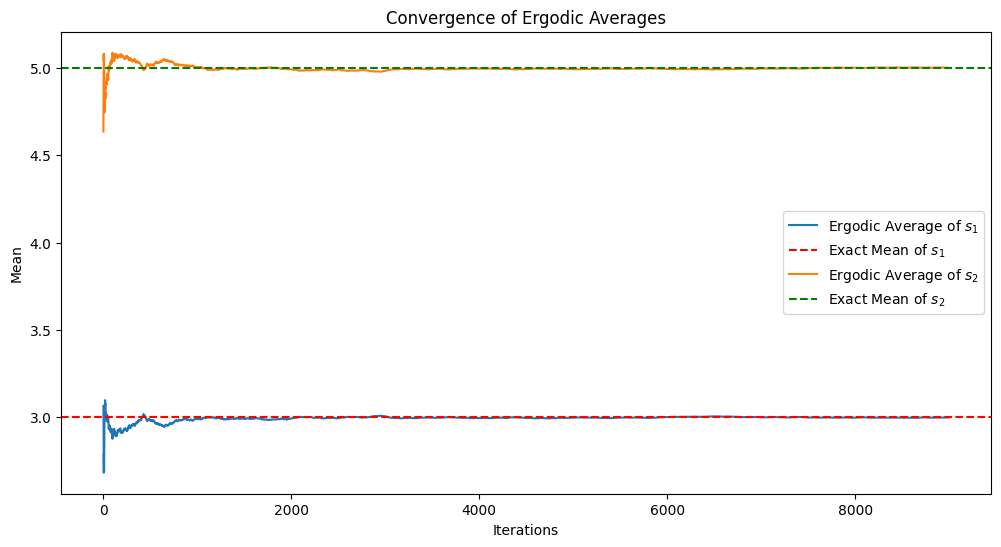

In [14]:
import numpy as np
import matplotlib.pyplot as plt

mu1, mu2 = 3.0, 5.0
P1, P2 = 0.5, 0.5
R = 0.3
x = 8.0 
np.random.seed(42)

def gibbs_sampler(mu1, mu2, P1, P2, R, x, n_iterations, burn_in):
    # Initialize
    s1 = np.zeros(n_iterations)
    s2 = np.zeros(n_iterations)
    s1[0] = mu1
    s2[0] = mu2

    
    for t in range(1,n_iterations-1):
        mu_s1 = (P1*(x-s2[t-1])+R*mu1)/(P1+R)
        sigma_s1 = np.sqrt((P1*R)/(P1+R))
        s1[t] = np.random.normal(mu_s1, sigma_s1)

        mu_s2 = (P2 * (x - s1[t]) + R * mu2) / (P2 + R)
        sigma_s2 = np.sqrt((P2 * R) / (P2 + R))
        s2[t] = np.random.normal(mu_s2, sigma_s2)

    s1 = s1[burn_in:-1]
    s2 = s2[burn_in:-1]

    return s1, s2

n_iterations = 10000
burn_in = 1000
s1, s2 = gibbs_sampler(mu1, mu2, P1, P2, R, x, n_iterations, burn_in)

s1_mean = np.cumsum(s1)/np.arange(1, len(s1)+1)
s2_mean = np.cumsum(s2)/np.arange(1, len(s2)+1)

s1_true = (P1*(x-mu2)+R*mu1)/(P1+R)
s2_true = (P2*(x-mu1)+R*mu2)/(P2+R)


def check_convergence(samples, exact_value, tolerance=0.05):
    errors = np.abs((samples - exact_value) / exact_value)
    return np.where(errors < tolerance)[0][0]

convergence_iter_s1 = check_convergence(s1_mean, s1_true)
convergence_iter_s2 = check_convergence(s2_mean, s2_true)

print(f"Convergence within 5% for s1: {convergence_iter_s1} iterations")
print(f"Convergence within 5% for s2: {convergence_iter_s2} iterations")

# Plot ergodic averages
plt.figure(figsize=(12, 6))
plt.plot(s1_mean, label="Ergodic Average of $s_1$")
plt.axhline(s1_true, color='red', linestyle='dashed', label="Exact Mean of $s_1$")
plt.plot(s2_mean, label="Ergodic Average of $s_2$")
plt.axhline(s2_true, color='green', linestyle='dashed', label="Exact Mean of $s_2$")
plt.xlabel("Iterations")
plt.ylabel("Mean")
plt.title("Convergence of Ergodic Averages")
plt.legend()
plt.show()

#### (2)Experiment 2
We can see that convergence rate is much slower than the first experiment: this is because, small $R$ implies a strong relationship between $s_{1}$ and $s_{2}$ (Consider the limit case, where R=0, then $s_{1}$ is determined by $s_{1}$). The update of parameters is much slower in this case.

Convergence within 5% for s1: 1768 iterations
Convergence within 5% for s2: 1069 iterations


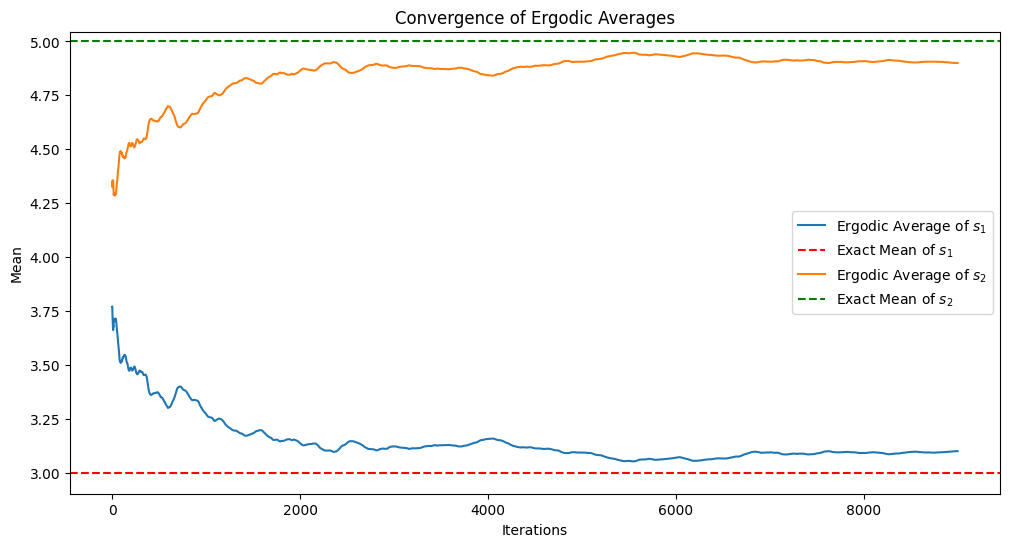

In [13]:
import numpy as np
import matplotlib.pyplot as plt

mu1, mu2 = 3.0, 5.0
P1, P2 = 0.5, 0.5
R = 0.005
x = 8.0 

n_iterations = 10000
burn_in = 1000
s1, s2 = gibbs_sampler(mu1, mu2, P1, P2, R, x, n_iterations, burn_in)

s1_mean = np.cumsum(s1)/np.arange(1, len(s1)+1)
s2_mean = np.cumsum(s2)/np.arange(1, len(s2)+1)


convergence_iter_s1 = check_convergence(s1_mean, s1_true)
convergence_iter_s2 = check_convergence(s2_mean, s2_true)

print(f"Convergence within 5% for s1: {convergence_iter_s1} iterations")
print(f"Convergence within 5% for s2: {convergence_iter_s2} iterations")

# Plot ergodic averages
plt.figure(figsize=(12, 6))
plt.plot(s1_mean, label="Ergodic Average of $s_1$")
plt.axhline(s1_true, color='red', linestyle='dashed', label="Exact Mean of $s_1$")
plt.plot(s2_mean, label="Ergodic Average of $s_2$")
plt.axhline(s2_true, color='green', linestyle='dashed', label="Exact Mean of $s_2$")
plt.xlabel("Iterations")
plt.ylabel("Mean")
plt.title("Convergence of Ergodic Averages")
plt.legend()
plt.show()